# Basic CFHT cluster data analysis using the LSST stack

## Initialize butler and get references to some deepCoadd catalogs

In [ ]:
import lsst.daf.persistence as dafPersist
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom

import math

# We are going to analyse the following patches. We assume that these patches are
# all in the same tract (0)
#patchList = ['3,3', '4,3']
patchList = ['3,3', '4,3', '3,4', '4,4']

# CL0016+16 coordinates
raClust = afwGeom.degToRad(4.6375)
deClust = afwGeom.degToRad(16.4369)

# Initialize butler
butler = dafPersist.Butler("/sps/lsst/dev/lsstprod/clusters/CL0016+16/output/coadd_dir")
#butler = dafPersist.Butler("/home/boutigny/LSST/CFHT/clusters/CL0016+16/output/coadd_dir_cc")

In [11]:
# Move reference point outside of the cluster for null test
#raClust = afwGeom.degToRad(4.8)
#deClust = afwGeom.degToRad(16.6)
# Get cluster center position in pixel coordinates
#wcs = md_i.getWcs()
#xClust, yClust = wcs.skyToPixel(afwGeom.Angle(raClust), afwGeom.Angle(deClust))

## print all the keys available in the deepCoad_meas catalog 

In [3]:
dataId_r = {'tract':0, 'filter':'r', 'patch':patchList[0]}
meas_r = butler.get('deepCoadd_meas', dataId=dataId_r)
schema = meas_r.getSchema()

print schema.getOrderedNames()

('id', 'coord_ra', 'coord_dec', 'parent', 'flags_negative', 'merge_footprint_i', 'merge_footprint_r', 'merge_footprint_z', 'merge_footprint_g', 'merge_footprint_u', 'merge_footprint_sky', 'merge_peak_i', 'merge_peak_r', 'merge_peak_z', 'merge_peak_g', 'merge_peak_u', 'merge_peak_sky', 'deblend_nChild', 'deblend_deblendedAsPsf', 'deblend_psfCenter_x', 'deblend_psfCenter_y', 'deblend_psfFlux', 'deblend_tooManyPeaks', 'deblend_parentTooBig', 'deblend_masked', 'deblend_skipped', 'deblend_rampedTemplate', 'deblend_patchedTemplate', 'deblend_hasStrayFlux', 'base_GaussianCentroid_x', 'base_GaussianCentroid_y', 'base_GaussianCentroid_flag', 'base_GaussianCentroid_flag_noPeak', 'base_NaiveCentroid_x', 'base_NaiveCentroid_y', 'base_NaiveCentroid_flag', 'base_NaiveCentroid_flag_noCounts', 'base_NaiveCentroid_flag_edge', 'base_SdssCentroid_x', 'base_SdssCentroid_y', 'base_SdssCentroid_xSigma', 'base_SdssCentroid_ySigma', 'base_SdssCentroid_flag', 'base_SdssCentroid_flag_edge', 'base_SdssCentroid_f

In [4]:
dataId_r = {'tract':0, 'filter':'r', 'patch':patchList[0]}
phot_r = butler.get('deepCoadd_forced_src', dataId=dataId_r)
schema = phot_r.getSchema()

print schema.getOrderedNames()

('objectId', 'coord_ra', 'coord_dec', 'parentObjectId', 'base_TransformedCentroid_x', 'base_TransformedCentroid_y', 'base_TransformedCentroid_flag', 'base_TransformedShape_xx', 'base_TransformedShape_yy', 'base_TransformedShape_xy', 'base_TransformedShape_flag', 'modelfit_DoubleShapeletPsfApprox_0_xx', 'modelfit_DoubleShapeletPsfApprox_0_yy', 'modelfit_DoubleShapeletPsfApprox_0_xy', 'modelfit_DoubleShapeletPsfApprox_0_x', 'modelfit_DoubleShapeletPsfApprox_0_y', 'modelfit_DoubleShapeletPsfApprox_0_0', 'modelfit_DoubleShapeletPsfApprox_0_1', 'modelfit_DoubleShapeletPsfApprox_0_2', 'modelfit_DoubleShapeletPsfApprox_0_3', 'modelfit_DoubleShapeletPsfApprox_0_4', 'modelfit_DoubleShapeletPsfApprox_0_5', 'modelfit_DoubleShapeletPsfApprox_1_xx', 'modelfit_DoubleShapeletPsfApprox_1_yy', 'modelfit_DoubleShapeletPsfApprox_1_xy', 'modelfit_DoubleShapeletPsfApprox_1_x', 'modelfit_DoubleShapeletPsfApprox_1_y', 'modelfit_DoubleShapeletPsfApprox_1_0', 'modelfit_DoubleShapeletPsfApprox_1_1', 'modelfit_D

In [2]:
for i, patch in enumerate(patchList) :
    
    dataId_r = {'tract':0, 'filter':'r', 'patch':patch}
    dataId_g = {'tract':0, 'filter':'g', 'patch':patch}
    dataId_i = {'tract':0, 'filter':'i', 'patch':patch}

    meas_r = butler.get('deepCoadd_meas', dataId=dataId_r)
    meas_g = butler.get('deepCoadd_meas', dataId=dataId_g)
    meas_i = butler.get('deepCoadd_meas', dataId=dataId_i)
    
    phot_r = butler.get('deepCoadd_forced_src', dataId=dataId_r)
    phot_g = butler.get('deepCoadd_forced_src', dataId=dataId_g)
    phot_i = butler.get('deepCoadd_forced_src', dataId=dataId_i)

    md_r = butler.get('deepCoadd_calexp', dataId=dataId_r)
    md_g = butler.get('deepCoadd_calexp', dataId=dataId_g)
    md_i = butler.get('deepCoadd_calexp', dataId=dataId_i)
    calib_r = md_r.getCalib()
    calib_g = md_g.getCalib()
    calib_i = md_i.getCalib()

    if i == 0 :
        schema = meas_r.getSchema()
        schema_phot = phot_r.getSchema()

        # Get keys from the measurement catalog
        # The following is not strictly necessary as one could use the get("key_name") method to access values in the
        # catalogs, but it is much more efficient to use get(key)
        fluxKey = schema_phot["modelfit_CModel_flux"].asKey()
        fluxSigmaKey = schema_phot["modelfit_CModel_fluxSigma"].asKey()
        fluxFlagKey = schema_phot["modelfit_CModel_flag"].asKey()
        extKey = schema["base_ClassificationExtendedness_value"].asKey()
        extFlagKey = schema["base_ClassificationExtendedness_flag"].asKey()
        nChildKey = schema["deblend_nChild"].asKey()

        e1Key = schema["ext_shapeHSM_HsmShapeRegauss_e1"].asKey()
        e2Key = schema["ext_shapeHSM_HsmShapeRegauss_e2"].asKey()
        regaussFlagKey = schema["ext_shapeHSM_HsmShapeRegauss_flag"].asKey()
        resKey = schema["ext_shapeHSM_HsmShapeRegauss_resolution"].asKey()

        raKey = schema["coord_ra"].asKey()
        decKey = schema["coord_dec"].asKey()
        
        # Get cluster center position in pixel coordinates
        wcs = md_i.getWcs()
        xClust, yClust = wcs.skyToPixel(afwGeom.Angle(raClust), afwGeom.Angle(deClust))

        # Initialize some lists
        magR = []
        magG = []
        magI = []
        e1R = []
        e2R = []
        e1I = []
        e2I = []
        raSrc = []
        decSrc = []
        res_i = []
        res_r = []
        xSrc = []
        ySrc = []

    # Loop over deblended sources in the r, g, and i deepCoadd_meas catalogs
    for i in range(len(meas_r)) :
        # Reject parent of deblended objects
        if meas_r[i].get(nChildKey) != 0 :
            continue
        # Select galaxies (and reject stars)
        if meas_r[i].get(extFlagKey) or meas_r[i].get(extKey) < 0.5 :
            continue
        # Select sources which have a proper flux value in r, g and i bands
        # Notice that it would not be strictly necessary with forced photometry
        if phot_r[i].get(fluxFlagKey) or phot_g[i].get(fluxFlagKey) or phot_i[i].get(fluxFlagKey) :
            continue
        flux_r = phot_r[i].get(fluxKey)
        flux_g = phot_g[i].get(fluxKey)
        flux_i = phot_i[i].get(fluxKey)
        if flux_r <= 0. or flux_g <= 0. or flux_i <= 0. :
            continue
        fluxS_r = phot_r[i].get(fluxSigmaKey)
        fluxS_g = phot_g[i].get(fluxSigmaKey)
        fluxS_i = phot_i[i].get(fluxSigmaKey)
        if flux_r/fluxS_r < 10. or flux_g/fluxS_g < 10. or flux_i/fluxS_i < 10. :
            continue
        if meas_r[i].get(regaussFlagKey) or meas_r[i].get(regaussFlagKey) :
            continue

        # Need to use a calibobject in order to convert flux to magnitude
        mag_r = calib_r.getMagnitude(flux_r)
        mag_g = calib_g.getMagnitude(flux_g)
        mag_i = calib_i.getMagnitude(flux_i)

        # Get ellipticities
        e1_i = meas_i[i].get(e1Key)
        e2_i = meas_i[i].get(e2Key)
        res_i.append(meas_i[i].get(resKey))
        e1_r = meas_r[i].get(e1Key)
        e2_r = meas_r[i].get(e2Key)
        res_r.append(meas_r[i].get(resKey))

        magR.append(mag_r)
        magG.append(mag_g)
        magI.append(mag_i)

        ra = meas_r[i].get(raKey)
        dec = meas_r[i].get(decKey)
        raSrc.append(float(ra))
        decSrc.append(float(dec))
        x, y = wcs.skyToPixel(ra, dec)
        xSrc.append(x)
        ySrc.append(y)

        e1R.append(e1_r)
        e2R.append(e2_r)
        e1I.append(e1_i)
        e2I.append(e2_i)

    print "Nbr. of selected sources after reading patch %s : %d"%(patch, len(magR))

Nbr. of selected sources after reading patch 3,3 : 2572
Nbr. of selected sources after reading patch 4,3 : 5137


## Analysis and plots

/home/boutigny/LSST/new/lsstsw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:84: RuntimeWarning: invalid value encountered in greater
/home/boutigny/LSST/new/lsstsw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:84: RuntimeWarning: invalid value encountered in less
/home/boutigny/LSST/new/lsstsw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:91: RuntimeWarning: invalid value encountered in less


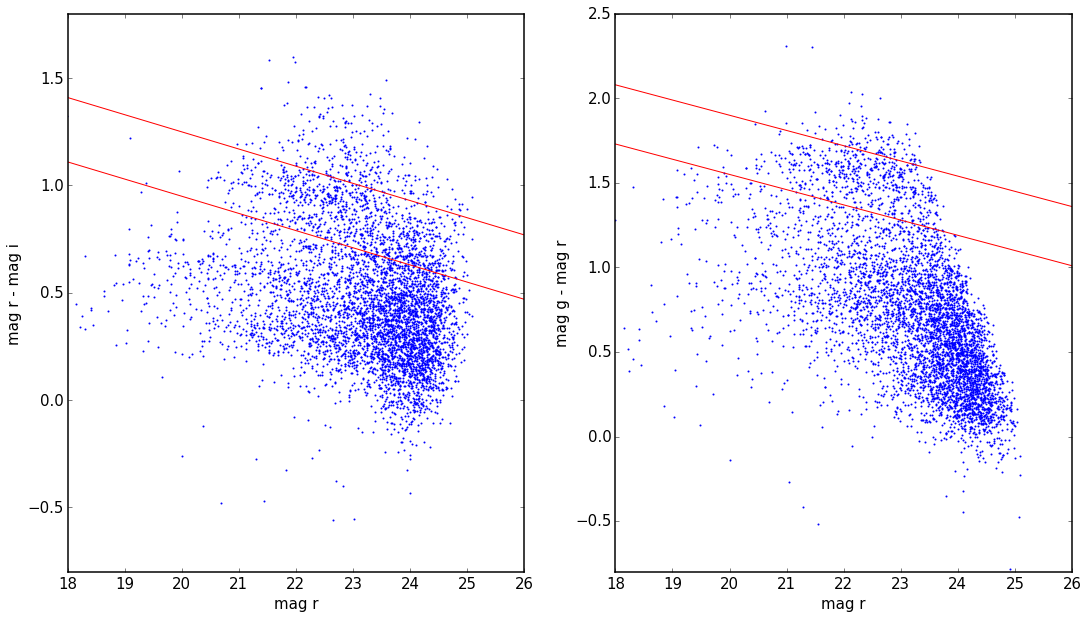

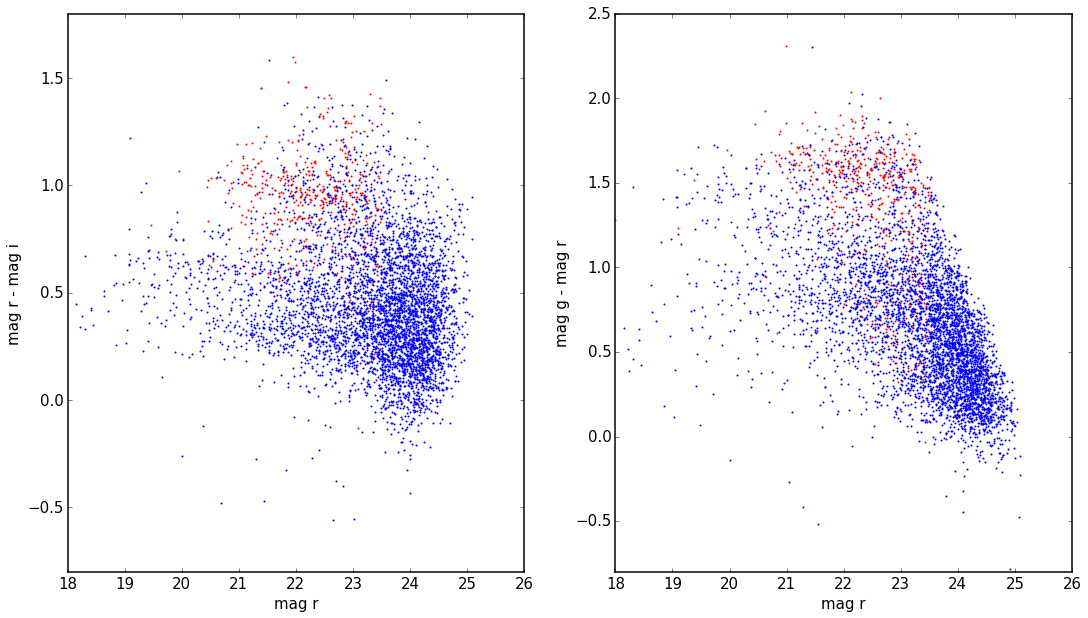

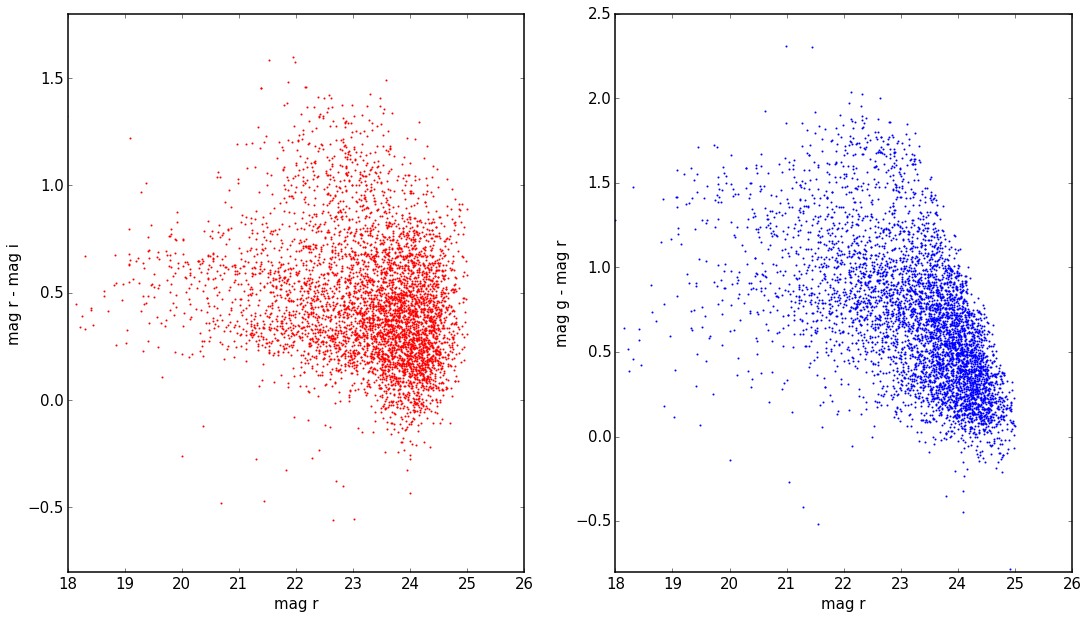

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'bold',
        'size'   : 25,
        }

plt.rcParams['axes.linewidth'] = 1.5 #set the value globally

# Plot magnitudes
#fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(18, 10))
#x0.hist(magR, bins=100)
#ax0.set_yscale('log')
#ax0.set_xlabel("mag r", fontsize=15)
#ax0.tick_params(labelsize=15)
#ax1.hist(magG, bins=100)
#ax1.set_yscale('log')
#ax1.set_xlabel("mag g", fontsize=15)
#ax1.tick_params(labelsize=15)
#ax2.hist(magI, bins=100)
#ax2.set_yscale('log')
#ax2.set_xlabel("mag i", fontsize=15)
#ax2.tick_params(labelsize=15)

# color plots : r-i Vs r and g-r Vs r 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 10))
ax1.scatter(np.asarray(magR),(np.asarray(magR)-np.asarray(magI)), s=1, color='b')
ax1.set_xlim([18., 26.])
ax1.set_ylim([-0.8, 1.8])
ax1.set_xlabel("mag r", fontsize=15)
ax1.set_ylabel("mag r - mag i", fontsize=15)
ax1.tick_params(labelsize=15)
ax2.scatter(np.asarray(magR),(np.asarray(magG)-np.asarray(magR)), s=1, color='b')
ax2.set_xlim([18., 26.])
ax2.set_ylim([-0.8, 2.5])
ax2.set_xlabel("mag r", fontsize=15)
ax2.set_ylabel("mag g - mag r", fontsize=15)
ax2.tick_params(labelsize=15)

# plot the red sequence bands corresponding to the foreground cluster
x = np.linspace(18., 26.)

# g-r
y1 = -0.09*x + 3.70
y2 = -0.09*x + 3.35
ax2.plot(x, y1, color='r')
ax2.plot(x, y2, color='r')

# r-i
y3 = -0.08*x + 2.85
y4 = -0.08*x + 2.55
ax1.plot(x, y3, color='r')
ax1.plot(x, y4, color='r')

gMinusR = np.asarray(magG)-np.asarray(magR)
yMax1 = -0.09*np.asarray(magR) + 3.70
yMin1 = -0.09*np.asarray(magR) + 3.35
indx = np.where((np.asarray(magR) < 23.5) & (gMinusR > yMin1) & (gMinusR < yMax1))
indx2 = np.where((np.asarray(magR) >= 23.5) | (gMinusR < yMin1) | (gMinusR > yMax1))

rMinusI = np.asarray(magR)-np.asarray(magI)
yMax2 = -0.08*np.asarray(magR) + 2.85
yMin2 = -0.08*np.asarray(magR) + 2.55
indx1p = np.where((np.asarray(magR) < 23.5) & (rMinusI > yMin2) & (rMinusI < yMax2))
indx3 = np.where((np.asarray(magR) >= 23.5) | (rMinusI < yMin2) | (rMinusI > yMax2))
indx4 = np.intersect1d(indx2, indx3)
indx5 = np.where((np.asarray(magR)) < 25)
indx6 = np.intersect1d(indx4, indx5)

# Define masks in order to reject cluster galaxies from the selection
mask1 = np.zeros(gMinusR.shape, dtype='bool')
mask1[indx] = True
mask2 = np.zeros(gMinusR.shape, dtype='bool')
mask2[indx1p] = True
mask3 = np.zeros(gMinusR.shape, dtype='bool')
mask3[indx5] = True
mask4 = ~(mask1*mask2) * mask3

indx6 = np.where(mask4)
indx7 = np.where((mask4) & (np.asarray(res_i)>0.4) & (np.fabs(np.asarray(e1I))<1) & (np.fabs(np.asarray(e2I))<1))

de1 = np.fabs(np.asarray(e1R)-np.asarray(e1I))
de2 = np.fabs(np.asarray(e2R)-np.asarray(e2I))

mask5 = np.zeros(gMinusR.shape, dtype='bool')
mask5[indx7] = True
indx8 = np.where((mask5) & (de1<0.5) & (de2<0.5))

# red dots correspond to galaxies associated to the cluster
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 10))
ax1.scatter(np.asarray(magR)[indx], rMinusI[indx], s=1, color='r')
ax1.scatter(np.asarray(magR)[indx2], rMinusI[indx2], s=1, color='b')
ax1.set_xlim([18., 26.])
ax1.set_ylim([-0.8, 1.8])
ax1.set_xlabel("mag r", fontsize=15)
ax1.set_ylabel("mag r - mag i", fontsize=15)
ax1.tick_params(labelsize=15)

ax2.scatter(np.asarray(magR)[indx1p], gMinusR[indx1p], s=1, color='r')
ax2.scatter(np.asarray(magR)[indx3], gMinusR[indx3], s=1, color='b')
ax2.set_xlim([18., 26.])
ax2.set_ylim([-0.8, 2.5])
ax2.set_xlabel("mag r", fontsize=15)
ax2.set_ylabel("mag g - mag r", fontsize=15)
ax2.tick_params(labelsize=15)

# color plots after galaxy cluster removal
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 10))
ax1.scatter(np.asarray(magR)[indx6], rMinusI[indx6], s=1, color='r')
ax1.set_xlim([18., 26.])
ax1.set_ylim([-0.8, 1.8])
ax1.set_xlabel("mag r", fontsize=15)
ax1.set_ylabel("mag r - mag i", fontsize=15)
ax1.tick_params(labelsize=15)

ax2.scatter(np.asarray(magR)[indx6], gMinusR[indx6], s=1, color='b')
ax2.set_xlim([18., 26.])
ax2.set_ylim([-0.8, 2.5])
ax2.set_xlabel("mag r", fontsize=15)
ax2.set_ylabel("mag g - mag r", fontsize=15)
ax2.tick_params(labelsize=15)

## shapeHSM resolution parameter

/home/boutigny/LSST/lsstsw/miniconda/lib/python2.7/site-packages/numpy/lib/function_base.py:229: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/boutigny/LSST/lsstsw/miniconda/lib/python2.7/site-packages/numpy/lib/function_base.py:230: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


(array([   5.,   10.,   10.,   17.,   13.,    8.,   18.,   24.,   23.,
          21.,   24.,   41.,   38.,   28.,   49.,   59.,   81.,   80.,
          86.,   78.,   98.,   95.,  121.,  117.,  104.,  127.,  133.,
         138.,  145.,  133.,  149.,  154.,  166.,  166.,  135.,  157.,
         157.,  186.,  176.,  189.,  206.,  170.,  178.,  168.,  163.,
         154.,  159.,  164.,  187.,  217.,  175.,  152.,  158.,  188.,
         147.,  156.,  131.,  149.,  146.,  145.,  154.,  125.,  110.,
         122.,  110.,  110.,   83.,   89.,  100.,   90.,   62.,   60.,
          60.,   38.,   28.,   20.,   20.,    9.,   24.,   18.]),
 array([ 0.    ,  0.0125,  0.025 ,  0.0375,  0.05  ,  0.0625,  0.075 ,
         0.0875,  0.1   ,  0.1125,  0.125 ,  0.1375,  0.15  ,  0.1625,
         0.175 ,  0.1875,  0.2   ,  0.2125,  0.225 ,  0.2375,  0.25  ,
         0.2625,  0.275 ,  0.2875,  0.3   ,  0.3125,  0.325 ,  0.3375,
         0.35  ,  0.3625,  0.375 ,  0.3875,  0.4   ,  0.4125,  0.425 ,
         0.

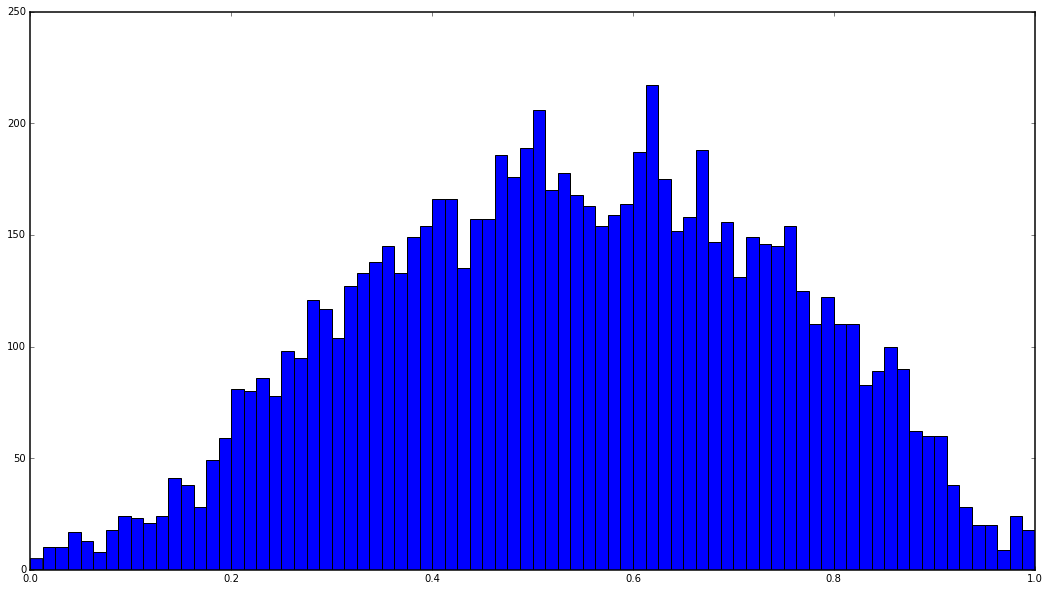

In [22]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'bold',
        'size'   : 25,
        }

plt.rcParams['axes.linewidth'] = 1.5 #set the value globally

fig, (ax0) = plt.subplots(ncols=1, figsize=(18, 10))
ax0.hist(np.asarray(res_i)[indx6], bins=80, range=[0,1])

In [27]:
print np.asarray(res_i)[indx6]

[ 0.59875512  0.35532656  0.80455756 ...,  0.50110167  0.2115283
  0.47671661]


(array([    4.,     9.,     8.,     7.,     5.,    12.,    11.,    18.,
           11.,    11.,    10.,    15.,    19.,    21.,    17.,    20.,
           26.,    35.,    40.,    37.,    45.,    57.,    55.,    60.,
           62.,    65.,    72.,    94.,   111.,    94.,   147.,   160.,
          193.,   238.,   262.,   292.,   411.,   575.,   719.,   964.,
         1001.,   732.,   560.,   397.,   362.,   287.,   241.,   192.,
          164.,   121.,   126.,   114.,    82.,    80.,    66.,    66.,
           69.,    49.,    41.,    45.,    26.,    20.,    35.,    30.,
           28.,    25.,    27.,    15.,    13.,    10.,    10.,    11.,
           10.,    13.,     8.,    10.,    11.,     7.,     4.,     3.]),
 array([-1.   , -0.975, -0.95 , -0.925, -0.9  , -0.875, -0.85 , -0.825,
        -0.8  , -0.775, -0.75 , -0.725, -0.7  , -0.675, -0.65 , -0.625,
        -0.6  , -0.575, -0.55 , -0.525, -0.5  , -0.475, -0.45 , -0.425,
        -0.4  , -0.375, -0.35 , -0.325, -0.3  , -0.275, -0.25 

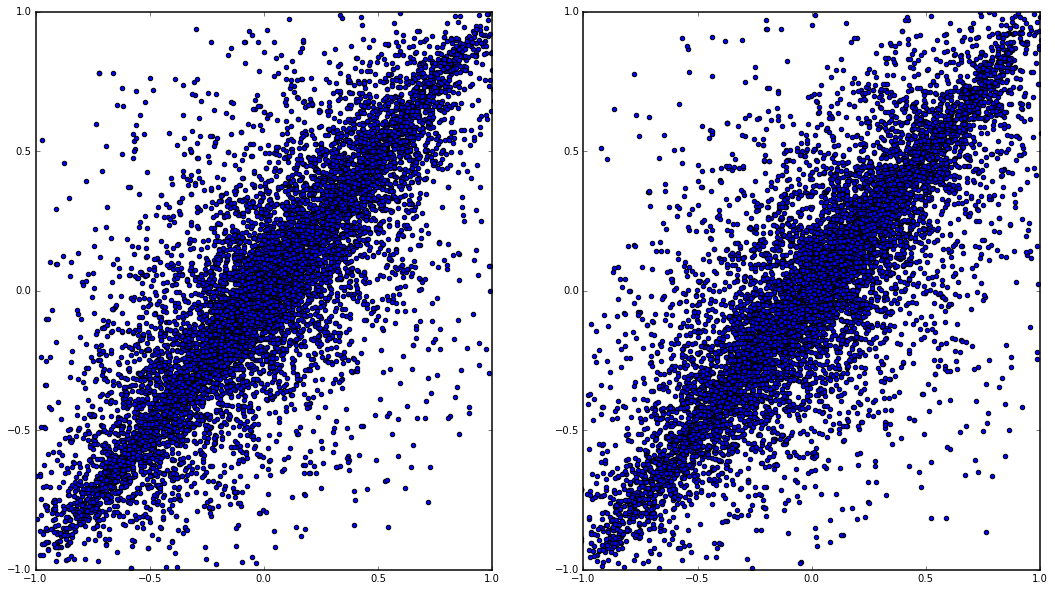

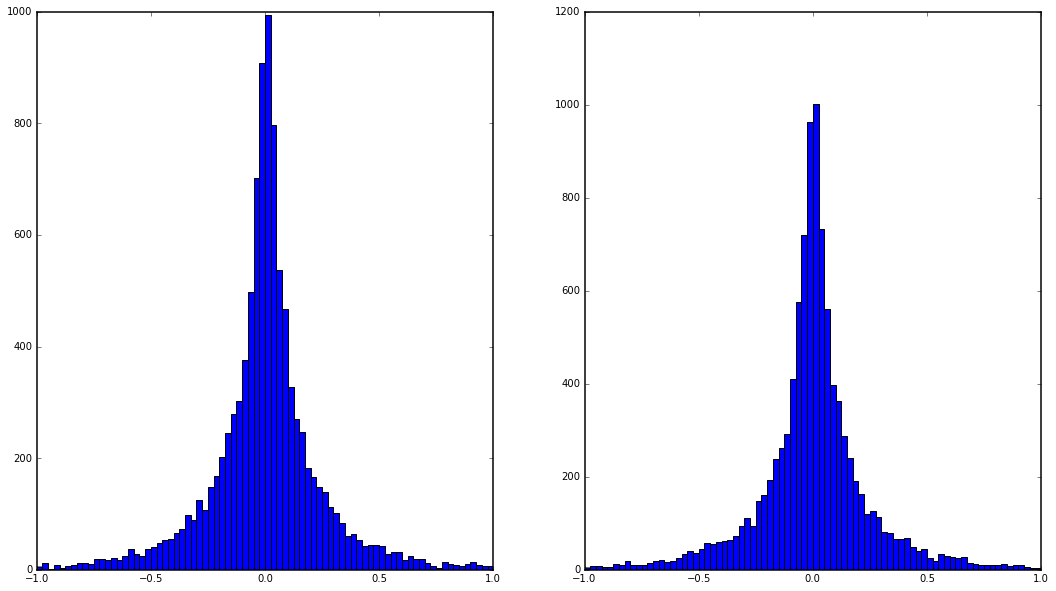

In [19]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'bold',
        'size'   : 25,
        }

plt.rcParams['axes.linewidth'] = 1.5 #set the value globally

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 10))
ax0.scatter(np.asarray(e1R)[indx7], np.asarray(e1I)[indx7])
ax1.scatter(np.asarray(e2R)[indx7], np.asarray(e2I)[indx7])
ax0.axis([-1, 1, -1, 1])
ax1.axis([-1, 1, -1, 1])

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 10))
ax0.hist(np.asarray(e1R)[indx7]-np.asarray(e1I)[indx7], bins=80, range=[-1,1])
ax1.hist(np.asarray(e2R)[indx7]-np.asarray(e2I)[indx7], bins=80, range=[-1,1])

## Plot some quantities related to ellipticities

Do not expect too much though...

/home/boutigny/LSST/new/lsstsw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in less
/home/boutigny/LSST/new/lsstsw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in greater
/home/boutigny/LSST/lsstsw/miniconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


0.00153478839475 nan


(-1.0, 1.0)

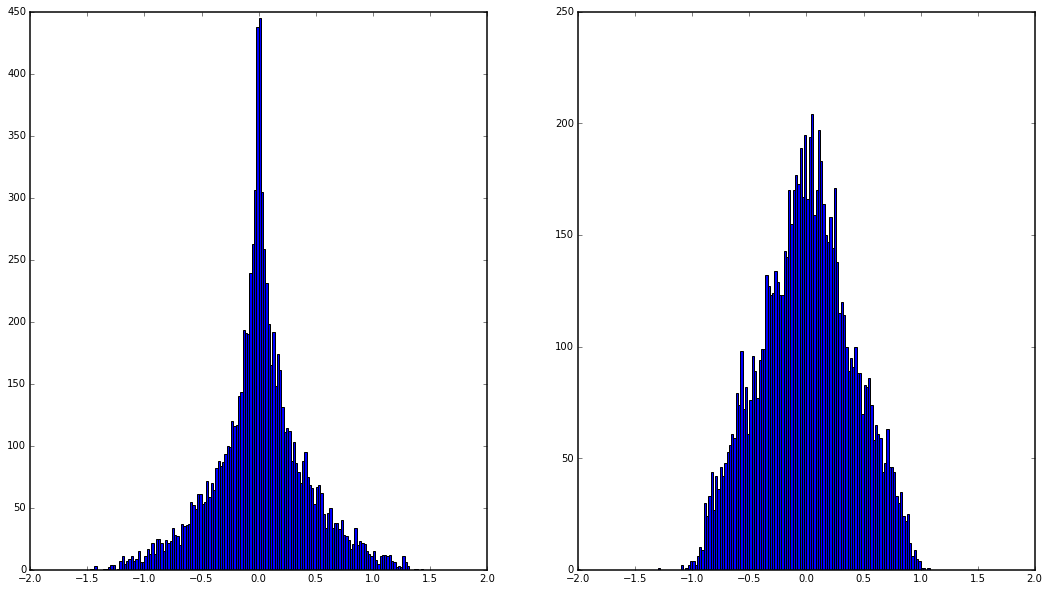

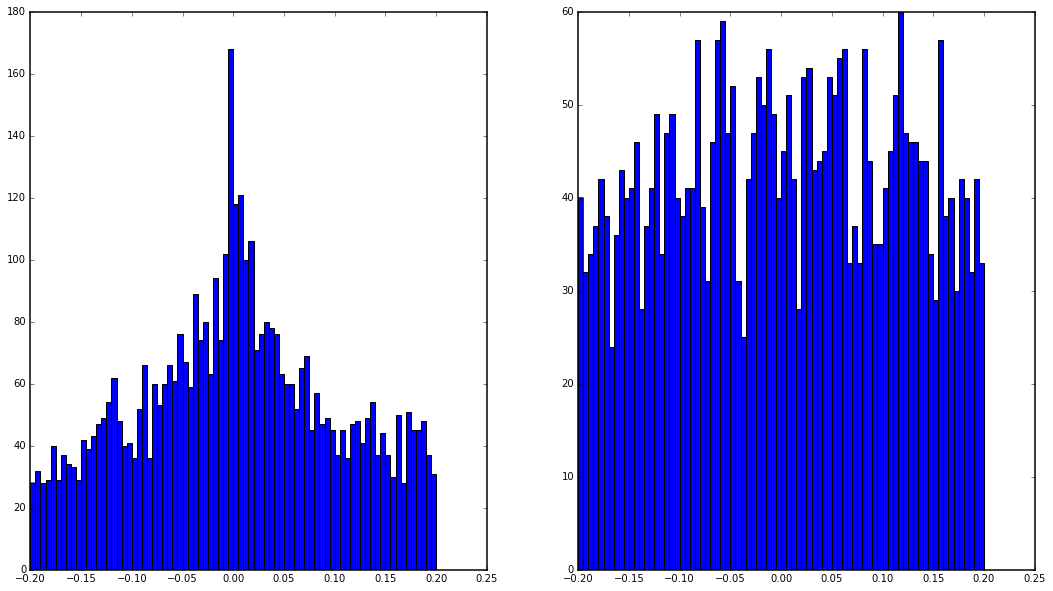

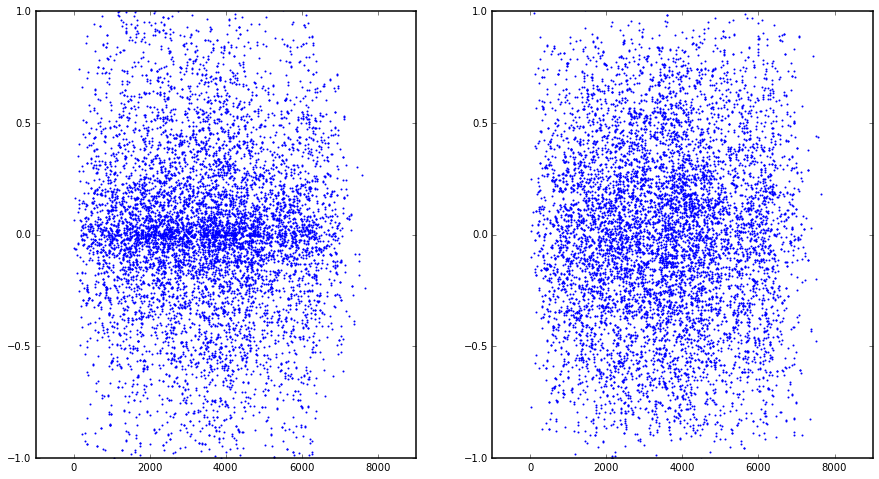

In [20]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'bold',
        'size'   : 25,
        }

plt.rcParams['axes.linewidth'] = 1.5 #set the value globally

#fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 10))
#ax0.hist(e1R, bins=100, range=[-5,5])
#ax1.hist(e2R, bins=100, range=[-5,5])

mod = np.hypot(np.asarray(e1R), np.asarray(e2R))
tg = np.asarray(e2R)/np.asarray(e1R)

#print np.mean(mod), np.median(mod)

#fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 10))
#ax0.hist(mod, bins=80, range=[0,2])
#ax1.hist(tg, bins=100, range=[-10,10])

phi = np.arctan2(np.asarray(ySrc)-yClust, np.asarray(xSrc)-xClust)
gamT = -(np.asarray(e1I)*np.cos(2.0*phi) + np.asarray(e2I)*np.cos(2.0*phi))
gamC = -np.asarray(e1I)*np.sin(2.0*phi) + np.asarray(e2I)*np.cos(2.0*phi)
dist = np.sqrt( (np.asarray(xSrc)-xClust)*(np.asarray(xSrc)-xClust) + 
        (np.asarray(ySrc)-yClust)*(np.asarray(ySrc)-yClust) )

indx = np.where((gamT<0.2) & (gamT>-0.2))

print np.median(gamT[indx]), np.median(gamC)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 10))
ax0.hist(gamT[indx8], bins=200, range=[-2,2])
ax1.hist(gamC[indx8], bins=200, range=[-2,2])

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 10))
ax0.hist(gamT[indx8], bins=80, range=[-0.2,0.2])
ax1.hist(gamC[indx8], bins=80, range=[-0.2,0.2])

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15,8))
ax0.scatter(dist[indx8], gamT[indx8], s=1, color='b')
ax0.set_ylim([-1.,1.])
ax1.scatter(dist[indx8], gamC[indx8], s=1, color='b')
ax1.set_ylim([-1.,1.])

(-0.06, 0.08)

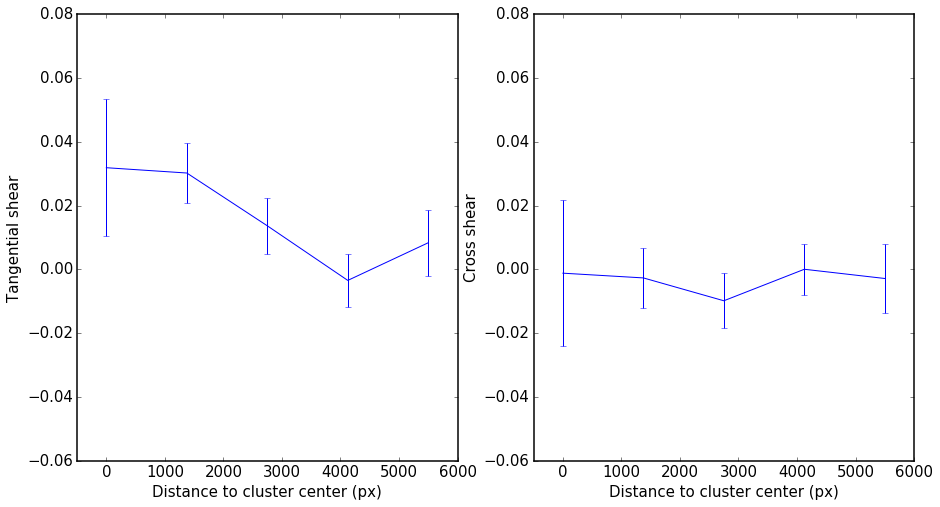

In [35]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'bold',
        'size'   : 25,
        }

plt.rcParams['axes.linewidth'] = 1.5 #set the value globally

dMin = 0.
dMax = 5500.
numStep = 5
dVal, step = np.linspace(dMin, dMax, num=numStep, retstep=True)

tShear = []
cShear = []
tShearE = []
cShearE = []
for d in dVal :
    mask1 = np.zeros(dist.shape, dtype='bool')
    mask1[indx8] = True
    idd = np.where( (dist > d-step/2) & (dist <= d+step/2) )
    mask2 = np.zeros(dist.shape, dtype='bool')
    mask2[idd] = True
    mask3 = mask1*mask2
    idd2 = np.where(mask3)
    n = len(gamT[idd2])
    tShear.append(np.mean(gamT[idd2]))
    cShear.append(np.mean(gamC[idd2]))
    tShearE.append(np.std(gamT[idd2])/np.sqrt(n))
    cShearE.append(np.std(gamC[idd2])/np.sqrt(n))
    
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 8))
ax0.errorbar(dVal,tShear,yerr=tShearE)
ax1.errorbar(dVal,cShear,yerr=cShearE)
ax0.tick_params(labelsize=15)
ax0.set_xlabel("Distance to cluster center (px)",fontsize=15)
ax0.set_ylabel("Tangential shear",fontsize=15)
ax0.set_xlim(-500, 6000)
ax0.set_ylim(-0.06, 0.08)
ax1.tick_params(labelsize=15)
ax1.set_xlabel("Distance to cluster center (px)",fontsize=15)
ax1.set_ylabel("Cross shear",fontsize=15)
ax1.set_xlim(-500, 6000)
ax1.set_ylim(-0.06, 0.08)

## Check centroid and classification extendedness

In [36]:
for i, patch in enumerate(patchList) :
    
    dataId_r = {'tract':0, 'filter':'r', 'patch':patch}
    dataId_g = {'tract':0, 'filter':'g', 'patch':patch}
    dataId_i = {'tract':0, 'filter':'i', 'patch':patch}

    meas_r = butler.get('deepCoadd_meas', dataId=dataId_r)
    meas_g = butler.get('deepCoadd_meas', dataId=dataId_g)
    meas_i = butler.get('deepCoadd_meas', dataId=dataId_i)

    md_r = butler.get('deepCoadd_calexp', dataId=dataId_r)
    md_g = butler.get('deepCoadd_calexp', dataId=dataId_g)
    md_i = butler.get('deepCoadd_calexp', dataId=dataId_i)
    calib_r = md_r.getCalib()
    calib_g = md_g.getCalib()
    calib_i = md_i.getCalib()

    if i == 0 :
        schema = meas_r.getSchema()

        # Get keys from the measurement catalog
        # The following is not strictly necessary as one could use the get("key_name") method to access values in the
        # catalogs, but it is much more efficient to use get(key)
        fluxKey = schema["modelfit_CModel_flux"].asKey()
        fluxSigmaKey = schema["modelfit_CModel_fluxSigma"].asKey()
        fluxFlagKey = schema["modelfit_CModel_flag"].asKey()
        extKey = schema["base_ClassificationExtendedness_value"].asKey()
        extFlagKey = schema["base_ClassificationExtendedness_flag"].asKey()

        e1Key = schema["ext_shapeHSM_HsmShapeRegauss_e1"].asKey()
        e2Key = schema["ext_shapeHSM_HsmShapeRegauss_e2"].asKey()
        regaussFlagKey = schema["ext_shapeHSM_HsmShapeRegauss_flag"].asKey()
        resKey = schema["ext_shapeHSM_HsmShapeRegauss_resolution"].asKey()

        xxSdssKey = schema["base_SdssShape_xx"].asKey()
        yySdssKey = schema["base_SdssShape_yy"].asKey()
        sdssFlagKey = schema["base_SdssShape_flag"].asKey()
        xxSourceKey = schema["ext_shapeHSM_HsmSourceMoments_xx"].asKey()
        yySourceKey = schema["ext_shapeHSM_HsmSourceMoments_yy"].asKey()
        xySourceKey = schema["ext_shapeHSM_HsmSourceMoments_xy"].asKey()
        sourceFlagKey = schema["ext_shapeHSM_HsmSourceMoments_flag"].asKey()

        xxPsfKey = schema["ext_shapeHSM_HsmPsfMoments_xx"].asKey()
        yyPsfKey = schema["ext_shapeHSM_HsmPsfMoments_yy"].asKey()
        xyPsfKey = schema["ext_shapeHSM_HsmPsfMoments_xy"].asKey()
        psfFlagKey = schema["ext_shapeHSM_HsmPsfMoments_flag"].asKey()

        raKey = schema["coord_ra"].asKey()
        decKey = schema["coord_dec"].asKey()
        
        # Get cluster center position in pixel coordinates
        wcs = md_i.getWcs()
        xClust, yClust = wcs.skyToPixel(afwGeom.Angle(raClust), afwGeom.Angle(deClust))

        # Initialize some lists
        magI = []
        extI = []
        xxSdss = []
        yySdss = []
        xxSource = []
        yySource = []
        xySource = []
        xxPsf = []
        yyPsf = []
        xyPsf = []
        res = []
        e1 = []
        e2 = []
        xSrc = []
        ySrc = []

    # Loop over deblended sources in the i deepCoadd_meas catalog
    for i in range(len(meas_i)) :
        if meas_i[i].get(extFlagKey) or meas_i[i].get(psfFlagKey) :
            continue
        if meas_i[i].get(fluxFlagKey) or meas_i[i].get(sdssFlagKey) or meas_i[i].get(sourceFlagKey) :
            continue
        flux_i = meas_i[i].get(fluxKey)
        if flux_i <= 0. :
            continue
        fluxS_i = meas_i[i].get(fluxSigmaKey)
        if flux_i/fluxS_i < 5. :
            continue
        mag_i = calib_i.getMagnitude(flux_i)

        if mag_i > 26 :
            continue

        magI.append(mag_i)
        extI.append(meas_r[i].get(extKey))
        xxSdss.append(meas_i[i].get(xxSdssKey))
        yySdss.append(meas_i[i].get(yySdssKey))
        xxSource.append(meas_i[i].get(xxSourceKey))
        yySource.append(meas_i[i].get(yySourceKey))
        xySource.append(meas_i[i].get(xySourceKey))
        xxPsf.append(meas_i[i].get(xxPsfKey))
        yyPsf.append(meas_i[i].get(yyPsfKey))
        xyPsf.append(meas_i[i].get(xyPsfKey))
        
        ra = meas_r[i].get(raKey)
        dec = meas_r[i].get(decKey)
        x, y = wcs.skyToPixel(ra, dec)
        xSrc.append(x)
        ySrc.append(y)

    print "Nbr. of selected sources after reading patch %s : %d"%(patch, len(magI))

Nbr. of selected sources after reading patch 1,1 : 2715
Nbr. of selected sources after reading patch 1,3 : 10587
Nbr. of selected sources after reading patch 1,2 : 17015
Nbr. of selected sources after reading patch 1,4 : 23878
Nbr. of selected sources after reading patch 1,5 : 30087
Nbr. of selected sources after reading patch 2,1 : 34704
Nbr. of selected sources after reading patch 2,2 : 46236
Nbr. of selected sources after reading patch 2,3 : 59312
Nbr. of selected sources after reading patch 2,4 : 73666
Nbr. of selected sources after reading patch 2,5 : 84559
Nbr. of selected sources after reading patch 3,2 : 97838
Nbr. of selected sources after reading patch 3,3 : 111631
Nbr. of selected sources after reading patch 3,4 : 126297


/home/boutigny/LSST/lsstsw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in less
/home/boutigny/LSST/lsstsw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in greater


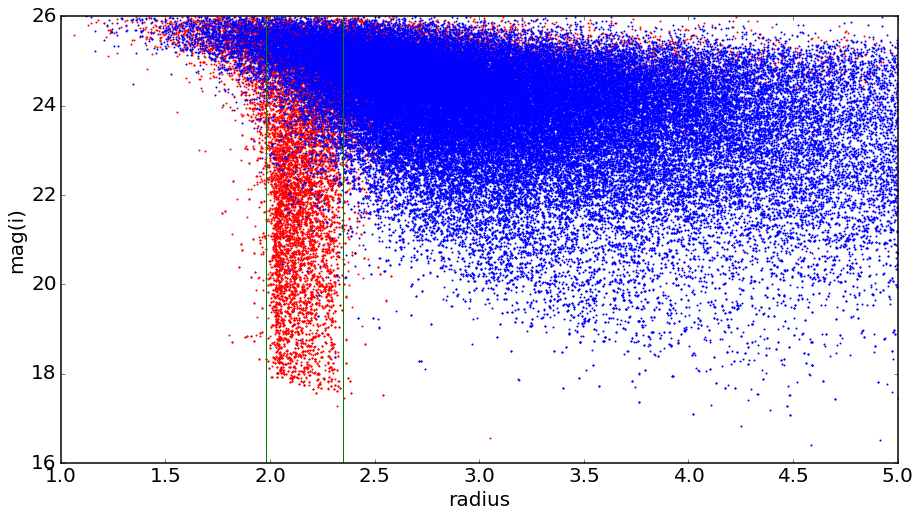

In [9]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'bold',
        'size'   : 25,
        }

plt.rcParams['axes.linewidth'] = 1.5 #set the value globally

r = np.sqrt(np.asarray(xxSdss)+np.asarray(yySdss))

indS = np.where((np.asarray(extI) < 0.5) & (r < 5))
indG = np.where((np.asarray(extI) > 0.5) & (r < 5))

fig, (ax0) = plt.subplots(ncols=1, figsize=(15, 8))
ax0.scatter(r[indS], np.asarray(magI)[indS], s=1, color="r")
ax0.scatter(r[indG], np.asarray(magI)[indG], s=1, color="b")
ax0.set_xlim([1., 5.])
ax0.set_ylim([16., 26.])
ax0.tick_params(labelsize=20)

y = np.linspace(16., 28.)
x1 = np.empty(y.shape)
x1.fill(1.98)
ax0.plot(x1, y, color='g')
x2 = np.empty(y.shape)
x2.fill(2.35)
ax0.plot(x2, y, color='g')
ax0.set_xlabel("radius", fontsize=20)
ax0.set_ylabel("mag(i)", fontsize=20)


## Check ellipticities of stars

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'bold',
        'size'   : 25,
        }

plt.rcParams['axes.linewidth'] = 1.5 #set the value globally

r = np.sqrt(np.asarray(xxSdss)+np.asarray(yySdss))

indS = np.where((np.asarray(extI) < 0.5) & (np.asarray(magI) < 24))
indG = np.where((np.asarray(extI) > 0.5) & (np.asarray(magI) < 24))

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 8))
ax0.hist(np.asarray(xxSdss)[indS], color="b", bins=80, range=[0., 10.])
ax1.hist(np.asarray(xxSource)[indS], color='b', bins=80, range=[0.,10.])
ax2.hist(np.asarray(xxPsf)[indS], bins=80, color='b')

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 8))
ax0.hist(np.asarray(yySdss)[indS], color="b", bins=80, range=[0., 10.])
ax1.hist(np.asarray(yySource)[indS], color='b', bins=80, range=[0.,10.])
ax2.hist(np.asarray(yyPsf)[indS], bins=80, range=[1.8,2.5], color='b')

/home/boutigny/LSST/lsstsw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in less


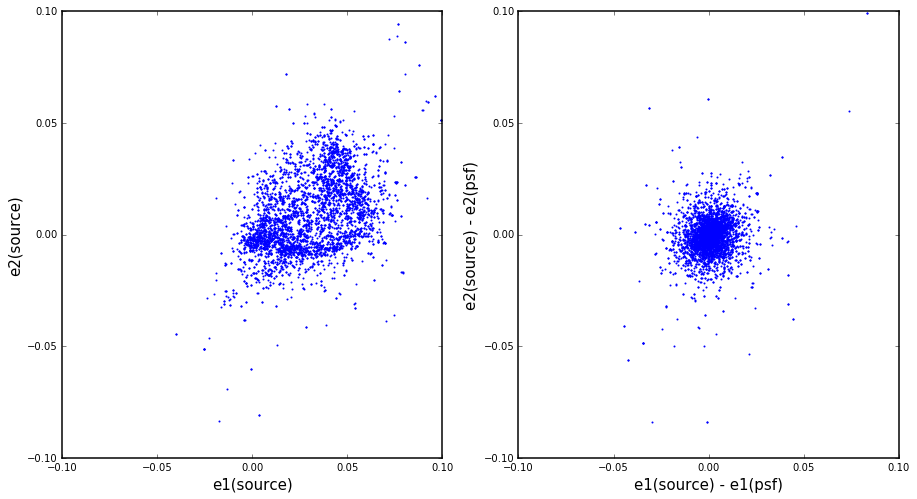

In [16]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'bold',
        'size'   : 25,
        }

plt.rcParams['axes.linewidth'] = 1.5 #set the value globally

denomSource = np.asarray(xxSource) + np.asarray(yySource) +2.0*np.sqrt(np.asarray(xxSource)*np.asarray(yySource)-
    np.square(np.asarray(xySource)))
e1Source = (np.asarray(xxSource) - np.asarray(yySource))/denomSource
e2Source = 2.0*np.asarray(xySource)/denomSource

denomPsf = np.asarray(xxPsf) + np.asarray(yyPsf) +2.0*np.sqrt(np.asarray(xxPsf)*np.asarray(yyPsf)-
    np.square(np.asarray(xyPsf)))
e1Psf = (np.asarray(xxPsf) - np.asarray(yyPsf))/denomPsf
e2Psf = 2.0*np.asarray(xyPsf)/denomPsf

indS = np.where((np.asarray(extI) < 0.5) & (np.asarray(magI) < 22.5) & (r>1.98) & (r<2.35))

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 8))
ax0.scatter(e1Source[indS], e2Source[indS], s=1, color='b')
ax1.scatter(e1Source[indS]-e1Psf[indS], e2Source[indS]-e2Psf[indS], s=1, color='b')
ax1.axis([-0.1, 0.1, -0.1, 0.1])
ax0.axis([-0.1, 0.1, -0.1, 0.1])
ax0.set_xlabel("e1(source)", fontsize=15)
ax0.set_ylabel("e2(source)", fontsize=15)
ax1.set_xlabel("e1(source) - e1(psf)", fontsize=15)
ax1.set_ylabel("e2(source) - e2(psf)", fontsize=15)

In [10]:
for i, patch in enumerate(patchList) :
    
    dataId_r = {'tract':0, 'filter':'r', 'patch':patch}
    dataId_g = {'tract':0, 'filter':'g', 'patch':patch}
    dataId_i = {'tract':0, 'filter':'i', 'patch':patch}

    meas_r = butler.get('deepCoadd_meas', dataId=dataId_r)
    meas_g = butler.get('deepCoadd_meas', dataId=dataId_g)
    meas_i = butler.get('deepCoadd_meas', dataId=dataId_i)

    md_r = butler.get('deepCoadd_calexp', dataId=dataId_r)
    md_g = butler.get('deepCoadd_calexp', dataId=dataId_g)
    md_i = butler.get('deepCoadd_calexp', dataId=dataId_i)
    calib_r = md_r.getCalib()
    calib_g = md_g.getCalib()
    calib_i = md_i.getCalib()

    if i == 0 :
        schema = meas_r.getSchema()

        # Get keys from the measurement catalog
        # The following is not strictly necessary as one could use the get("key_name") method to access values in the
        # catalogs, but it is much more efficient to use get(key)
        fluxKey = schema["modelfit_CModel_flux"].asKey()
        fluxSigmaKey = schema["modelfit_CModel_fluxSigma"].asKey()
        fluxFlagKey = schema["modelfit_CModel_flag"].asKey()
        extKey = schema["base_ClassificationExtendedness_value"].asKey()
        extFlagKey = schema["base_ClassificationExtendedness_flag"].asKey()

        e1Key = schema["ext_shapeHSM_HsmShapeRegauss_e1"].asKey()
        e2Key = schema["ext_shapeHSM_HsmShapeRegauss_e2"].asKey()
        regaussFlagKey = schema["ext_shapeHSM_HsmShapeRegauss_flag"].asKey()

#        xxKey = schema["base_SdssShape_xx"].asKey()
#        yyKey = schema["base_SdssShape_yy"].asKey()
#        sdssFlagKey = schema["base_SdssShape_flag"].asKey()
        xxKey = schema["ext_shapeHSM_HsmSourceMoments_xx"].asKey()
        yyKey = schema["ext_shapeHSM_HsmSourceMoments_yy"].asKey()
        momentFlagKey = schema["ext_shapeHSM_HsmSourceMoments_flag"].asKey()
#        xxKey = schema["ext_shapeHSM_HsmPsfMoments_xx"].asKey()
#        yyKey = schema["ext_shapeHSM_HsmPsfMoments_yy"].asKey()
#        momentFlagKey = schema["ext_shapeHSM_HsmPsfMoments_flag"].asKey()
        
        xxPsfKey = schema["ext_shapeHSM_HsmPsfMoments_xx"].asKey()
        yyPsfKey = schema["ext_shapeHSM_HsmPsfMoments_yy"].asKey()
        PsfFlagKey = schema["ext_shapeHSM_HsmPsfMoments_flag"].asKey()

        xxHSMKey = schema["ext_shapeHSM_HsmPsfMoments_xx"].asKey()
        yyHSMKey = schema["ext_shapeHSM_HsmPsfMoments_yy"].asKey()
        HSMFlagKey = schema["ext_shapeHSM_HsmPsfMoments_flag"].asKey()

        raKey = schema["coord_ra"].asKey()
        decKey = schema["coord_dec"].asKey()

        # Initialize some lists
        magI = []
        e1 = []
        e2 = []
        xx = []
        yy = []
        x = []
        y = []
        xxPsf = []
        yyPsf = []

    # Loop over deblended sources in the i deepCoadd_meas catalog
    for i in range(len(meas_i)) :
        if meas_i[i].get(extFlagKey) :
            continue
        if meas_i[i].get(fluxFlagKey) :
            continue
        flux_i = meas_i[i].get(fluxKey)
        if flux_i <= 0. :
            continue
        fluxS_i = meas_i[i].get(fluxSigmaKey)
        if flux_i/fluxS_i < 5. :
            continue
        mag_i = calib_i.getMagnitude(flux_i)

        if mag_i > 24 or meas_i[i].get(momentFlagKey):
            continue

        r = math.sqrt(meas_i[i].get(xxKey) + meas_i[i].get(yyKey))
        if r < 2.05 or r > 2.25 :
            continue

        if meas_i[i].get(regaussFlagKey) :
            continue

        magI.append(mag_i)
        e1.append(meas_i[i].get(e1Key))
        e2.append(meas_i[i].get(e2Key))

        x.append(meas_i[i].getX())
        y.append(meas_i[i].getY())
        xx.append(meas_i[i].get(xxKey))
        yy.append(meas_i[i].get(yyKey))
        xxPsf.append(meas_i[i].get(xxPsfKey))
        yyPsf.append(meas_i[i].get(yyPsfKey))

    print "Nbr. of selected sources after reading patch %s : %d"%(patch, len(magI))

Nbr. of selected sources after reading patch 1,3 : 183
Nbr. of selected sources after reading patch 2,3 : 645


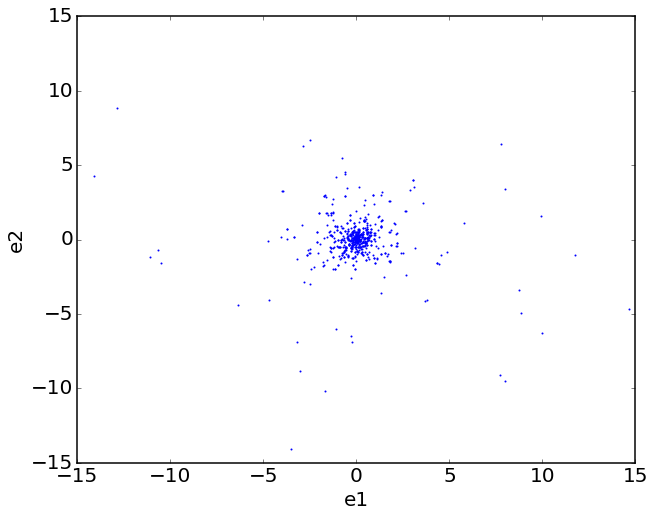

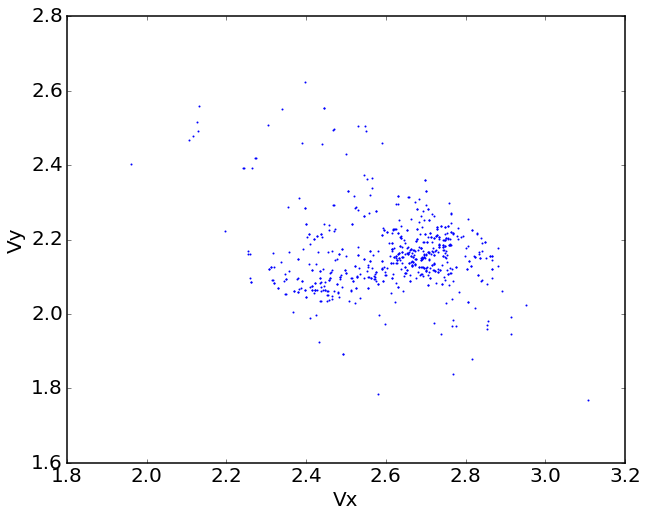

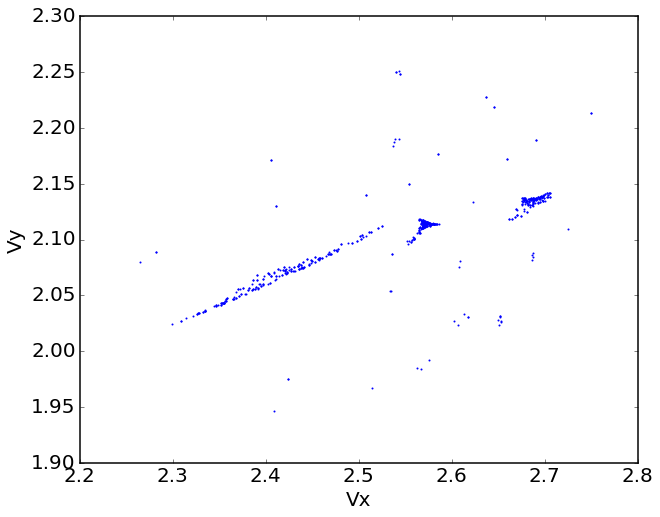

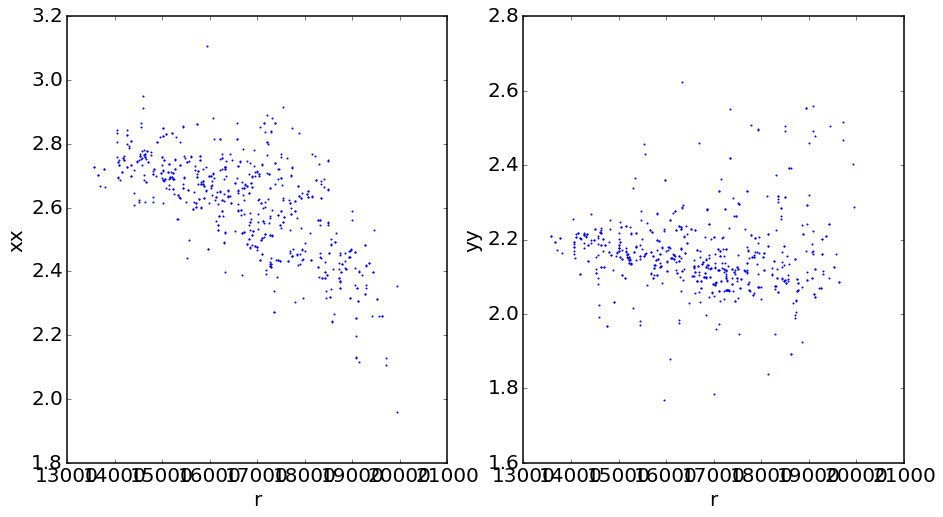

In [11]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'bold',
        'size'   : 25,
        }

plt.rcParams['axes.linewidth'] = 1.5 #set the value globally

phi = 0.5*np.arctan2(np.asarray(e2), np.asarray(e1))
fig, (ax0) = plt.subplots(ncols=1, figsize=(10, 8))
ax0.scatter(e1, e2, s=1, color="b")
ax0.set_xlim([-15, 15])
ax0.set_ylim([-15, 15])
ax0.set_xlabel("e1", fontsize=20)
ax0.set_ylabel("e2", fontsize=20)
ax0.tick_params(labelsize=20)

fig, (ax0) = plt.subplots(ncols=1, figsize=(10, 8))
ax0.scatter(xx, yy, s=1, color="b")
#ax0.set_xlim([-5, 5])
#ax0.set_ylim([-5, 5])
ax0.set_xlabel("Vx", fontsize=20)
ax0.set_ylabel("Vy", fontsize=20)
ax0.tick_params(labelsize=20)

fig, (ax0) = plt.subplots(ncols=1, figsize=(10, 8))
ax0.scatter(xxPsf, yyPsf, s=1, color="b")
#ax0.set_xlim([-5, 5])
#ax0.set_ylim([-5, 5])
ax0.set_xlabel("Vx", fontsize=20)
ax0.set_ylabel("Vy", fontsize=20)
ax0.tick_params(labelsize=20)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 8))
r = np.sqrt(np.asarray(x)*np.asarray(x)+np.asarray(y)*np.asarray(y))
ax0.scatter(r, xx, s=1, color="b")
ax0.set_xlabel("r", fontsize=20)
ax0.set_ylabel("xx", fontsize=20)
ax0.tick_params(labelsize=20)
ax1.scatter(r, yy, s=1, color="b")
ax1.set_xlabel("r", fontsize=20)
ax1.set_ylabel("yy", fontsize=20)
ax1.tick_params(labelsize=20)

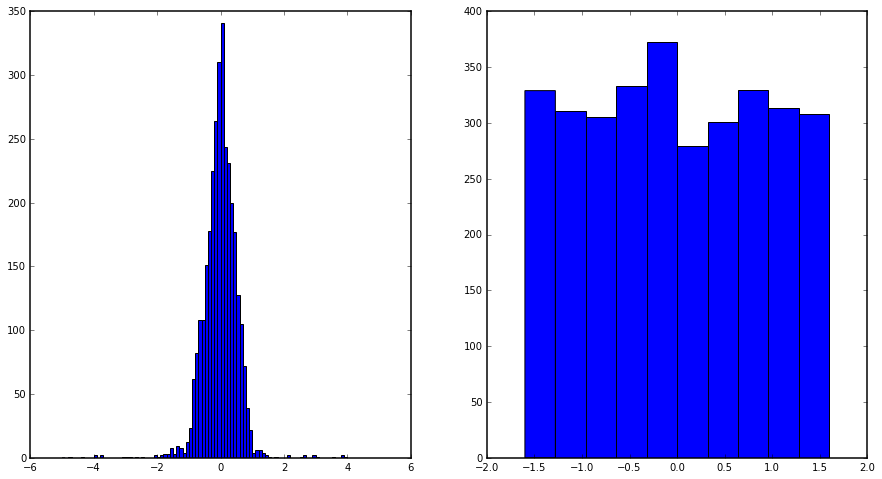

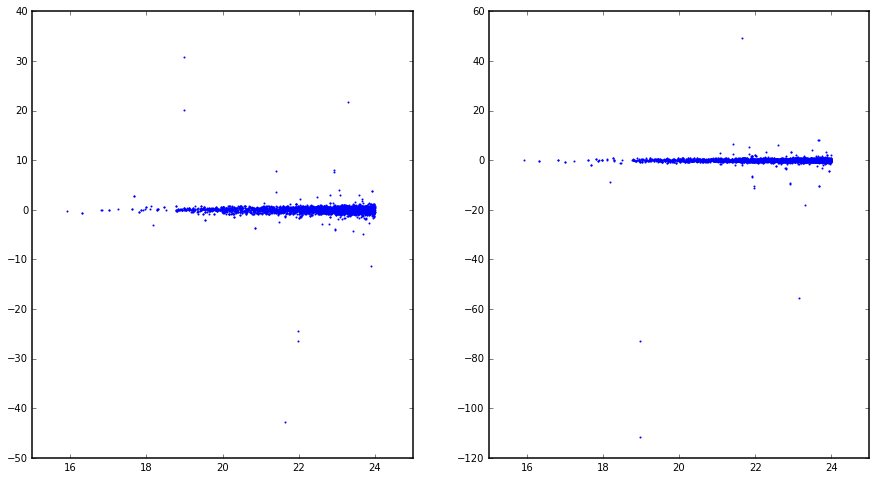

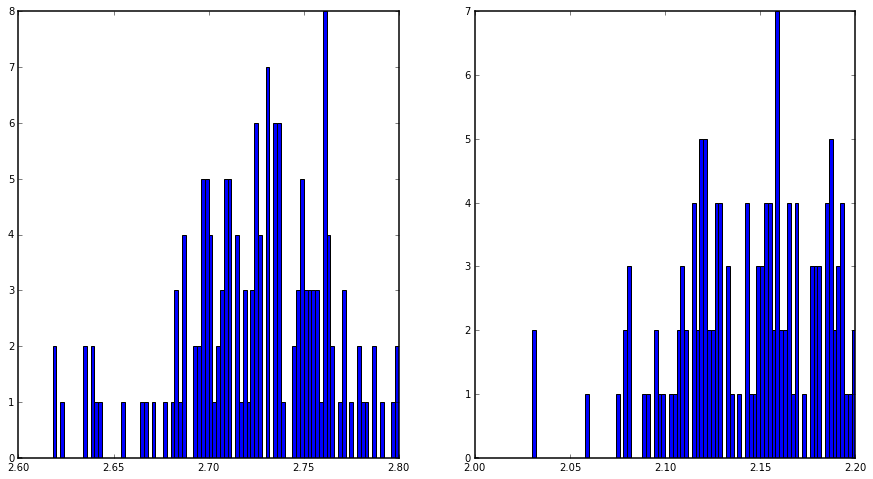

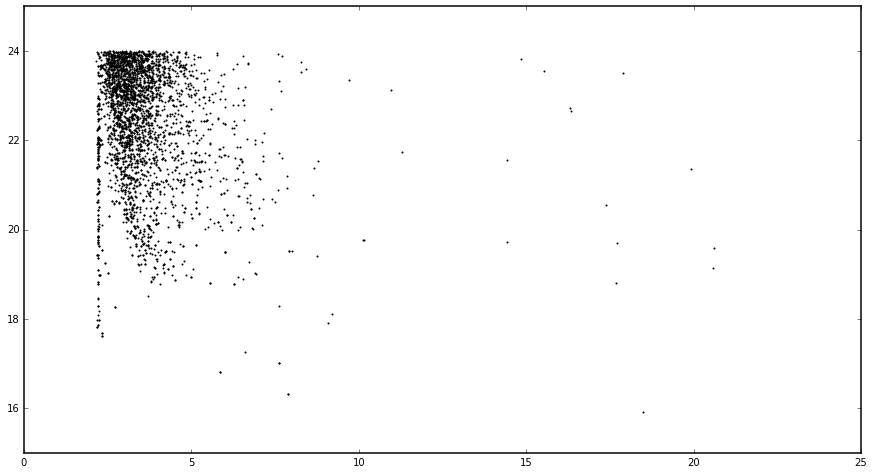

In [56]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'bold',
        'size'   : 25,
        }

plt.rcParams['axes.linewidth'] = 1.5 #set the value globally

phi = 0.5*np.arctan2(np.asarray(e2R), np.asarray(e1R))
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 8))
ax0.hist(e1R, bins=100, range=[-5,5])
ax1.hist(phi, bins=10, range=[-1.6,1.6])

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 8))
ax0.scatter(magI, e1R, s=1, color='b')
ax1.scatter(magI, e2R, s=1, color='b')

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 8))
ax0.hist(xx, bins=100, range=[2.6,2.8])
ax1.hist(yy, bins=100, range=[2.0,2.2])

r = np.sqrt(np.asarray(xx)+np.asarray(yy))
fig, (ax0) = plt.subplots(ncols=1, figsize=(15, 8))
ax0.scatter(r, magI, s=1)

In [13]:
import lsst.afw.display.ds9 as ds9

dataId = {'tract':0, 'filter':'i', 'patch':'1,3'}

exp = butler.get('deepCoadd', dataId)
wcs = exp.getWcs()
X0 = exp.getX0()
Y0 = exp.getY0()

ds9.mtv(exp.getMaskedImage().getImage(),frame=1, wcs=wcs)

for i in range(len(meas_i)) :
    # Select stars (and reject galaxies)
    if meas_i[i].get(extFlagKey) or meas_i[i].get(extKey) > 0.5 :
        continue
    
    flux_i = meas_i[i].get(fluxKey)
    if flux_i <= 0. :
        continue
    mag_i = calib_i.getMagnitude(flux_i)
    if mag_i > 24 :
        continue
    if meas_i[i].get(sdssFlag) :
        continue
        
    sx = meas_i[i].get(xxKey)
    sy = meas_i[i].get(yyKey)
    
    if sx > 3. or sy > 3. :
#        ra = meas_i[i].get(raKey)
#        dec = meas_i[i].get(decKey)
#        pixel = wcs.skyToPixel(ra, dec)
#        print pixel
        x = meas_i[i].get("base_SdssCentroid_x")
        y = meas_i[i].get("base_SdssCentroid_y")
        print sx, sy, x, y
        with ds9.Buffering():
            ds9.dot('o', x, y, frame=1, size=10)

ds9 doesn't appear to be running (XPA: XPA returned NULL, (;iconify no; raise)), I'll try to exec it for you


NameError: name 'sdssFlag' is not defined

In [30]:
print dir(exp)

['Factory', '__class__', '__del__', '__delattr__', '__dict__', '__doc__', '__float__', '__format__', '__getattr__', '__getattribute__', '__getitem__', '__hash__', '__init__', '__int__', '__module__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', '__swig_destroy__', '__swig_getmethods__', '__swig_setmethods__', '__weakref__', '_s', 'census', 'clone', 'getBBox', 'getCalib', 'getDetector', 'getDimensions', 'getFilter', 'getHeight', 'getId', 'getInfo', 'getMaskedImage', 'getMetadata', 'getNextMemId', 'getPsf', 'getWcs', 'getWidth', 'getX0', 'getXY0', 'getY0', 'hasBeenCorrupted', 'hasPsf', 'hasWcs', 'init', 'magicSentinel', 'markPersistent', 'readFits', 'repr', 'setCalib', 'setCorruptionCallback', 'setDeleteCallback', 'setDeleteCallbackId', 'setDetector', 'setFilter', 'setMaskedImage', 'setMetadata', 'setNewCallback', 'setNewCallbackId', 'setPsf', 'setWcs', 'setXY0', 'swigConvert', 'this', 'writeFits']


In [25]:
print dir(meas_i[10])

['Catalog', 'ColumnView', 'Table', '__class__', '__del__', '__delattr__', '__dict__', '__doc__', '__eq__', '__format__', '__getattr__', '__getattribute__', '__getitem__', '__hash__', '__init__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', '__swig_destroy__', '__swig_getmethods__', '__swig_setmethods__', '__weakref__', '_cast', '_eq_impl', '_s', 'assign', 'cast', 'extract', 'get', 'getAngle', 'getApFlux', 'getApFluxErr', 'getApFluxFlag', 'getArrayD', 'getArrayF', 'getArrayI', 'getArrayU', 'getCalibFlux', 'getCalibFluxErr', 'getCalibFluxFlag', 'getCentroid', 'getCentroidErr', 'getCentroidFlag', 'getCoord', 'getD', 'getDec', 'getF', 'getFlag', 'getFootprint', 'getI', 'getId', 'getInstFlux', 'getInstFluxErr', 'getInstFluxFlag', 'getIxx', 'getIxy', 'getIyy', 'getL', 'getManager', 'getModelFlux', 'getModelFluxErr', 'getModelFluxFlag', 'getParent', 'getPsfFlux', 'getPsfFluxErr', 'getPs

In [36]:
print meas_i[10].getShape()
print meas_i[10].get("base_SdssShape_xx"), meas_i[10].get("base_SdssShape_yy")
print meas_i[10].get("ext_shapeHSM_HsmSourceMoments_xx"), meas_i[10].get("ext_shapeHSM_HsmSourceMoments_yy")
print meas_i[10].getX(), meas_i[10].getY()

(ixx=13.3352395773, iyy=6.70832329435, ixy=3.57213102058)
13.384730464 6.7725899406
13.3352395773 6.70832329435
11243.1662591 6353.49313886


In [81]:
raClust = afwGeom.degToRad(340.83)
deClust = afwGeom.degToRad(-9.59)
#raClust = afwGeom.degToRad(340.93)
#deClust = afwGeom.degToRad(-9.49)
# Get cluster center position in pixel coordinates
wcs = md_i.getWcs()
xClust, yClust = wcs.skyToPixel(afwGeom.Angle(raClust), afwGeom.Angle(deClust))